In [1]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 1_Basic Text Classification

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

#### Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

#### Download and explore the IMDB dataset
Let's download and extract the dataset, then explore the directory structure.

In [50]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [6]:
pos_dir = os.path.join(train_dir, 'pos')
os.listdir(pos_dir)

['0_9.txt',
 '10000_8.txt',
 '10001_10.txt',
 '10002_7.txt',
 '10003_8.txt',
 '10004_8.txt',
 '10005_7.txt',
 '10006_7.txt',
 '10007_7.txt',
 '10008_7.txt',
 '10009_9.txt',
 '1000_8.txt',
 '10010_7.txt',
 '10011_9.txt',
 '10012_8.txt',
 '10013_7.txt',
 '10014_8.txt',
 '10015_8.txt',
 '10016_8.txt',
 '10017_9.txt',
 '10018_8.txt',
 '10019_8.txt',
 '1001_8.txt',
 '10020_8.txt',
 '10021_8.txt',
 '10022_7.txt',
 '10023_9.txt',
 '10024_9.txt',
 '10025_9.txt',
 '10026_7.txt',
 '10027_7.txt',
 '10028_10.txt',
 '10029_10.txt',
 '1002_7.txt',
 '10030_10.txt',
 '10031_10.txt',
 '10032_10.txt',
 '10033_10.txt',
 '10034_8.txt',
 '10035_9.txt',
 '10036_8.txt',
 '10037_9.txt',
 '10038_10.txt',
 '10039_10.txt',
 '1003_10.txt',
 '10040_10.txt',
 '10041_10.txt',
 '10042_10.txt',
 '10043_10.txt',
 '10044_9.txt',
 '10045_10.txt',
 '10046_9.txt',
 '10047_10.txt',
 '10048_10.txt',
 '10049_8.txt',
 '1004_7.txt',
 '10050_10.txt',
 '10051_10.txt',
 '10052_10.txt',
 '10053_8.txt',
 '10054_10.txt',
 '10055_7.tx

In [7]:
sample_file = os.path.join(train_dir, 'pos/10000_8.txt')
with open(sample_file) as f:
  print(f.read())

Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without th

#### Load the dataset
Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

In [8]:
'''
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
'''

'\nmain_directory/\n...class_a/\n......a_text_1.txt\n......a_text_2.txt\n...class_b/\n......b_text_1.txt\n......b_text_2.txt\n'

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: train, validation, and test.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [10]:
batch_size = 32
seed = 42

#Training set
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to model.fit. If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.

In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print(f"Review: {text_batch.numpy()[i]}")
    print(f"Label: {label_batch.numpy()[i]}")
    print("-----------")

Review: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
Label: 0
-----------
Review: b"I am shocked. Shocked and dismayed that the 428 of you IMDB users who voted before me have not given this film a rating of higher than 7. 7?!?? - that's a C!. If I could give FOBH a 20, I'd gladly do it. This film ranks high atop the pantheon of modern comedy, alongside Half Baked and Mallrats, as one of the most hilarious films of all time. If you know _anything_ about rap music - YOU MUST SEE THIS!! If you know nothing about rap music - learn something!, and then see this! Comparisons to 'Spinal Tap' fail to appreciate the inspired genius of this unique film. If you liked Bob Roberts, you'll love this. Watch it and vote it a 10!"
Label: 1
-----------
Review: b'What a lovely heart warming television movie. The story tells of a little five year old girl who has lost her daddy and finds it impossible to cope. Her mot

Notice the reviews contain raw text (with punctuation and occasional HTML tags like <\br). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

In [16]:
#Validation set
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [17]:
#Test set - already exist under test folder
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


#### Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <\br>. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [20]:
#Define custom standardization
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) #change to lowercase
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #replace <br /> with space
  return tf.strings.regex_replace(stripped_html, 
                                  '[%s]' % re.escape(string.punctuation), #creates a string with escaped punctuation characters
                                  '') #goes through stripped_html and replaces all punctuation with empty string ''

Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the output_mode to int to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [18]:
#Constants
max_features = 10000
sequence_length = 250

In [21]:
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [22]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x) #lambda - takes two inputs x and y, and only returns x
vectorize_layer.adapt(train_text)

In [24]:
#Let's create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [30]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review:", first_review)
print("Label:", raw_train_ds.class_names[first_label])
print("-------")
print("Vectorized review", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'"A young woman suffers from the delusion that she is a werewolf, based upon a family legend of an ancestor accused of and killed for allegedly being one. Due to her past treatment by men, she travels the countryside seducing and killing the men she meets. Falling in love with a kind man, her life appears to take a turn for the better when she is raped and her lover is killed by a band of thugs. Traumatized again by these latest events, the woman returns to her violent ways and seeks revenge on the thugs," according to the DVD sleeve\'s synopsis.<br /><br />Rino Di Silvestro\'s "La lupa mannara" begins with full frontal, writhing, moaning dance by shapely blonde Annik Borel, who (as Daniella Neseri) mistakenly believes she is a werewolf. The hottest part is when the camera catches background fire between her legs. The opening "flashback" reveals her hairy ancestor was (probably) a lycanthropic creature. Ms. Borel is, unfortunately, not a werewolf; she is merely a ver

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [32]:
print(vectorize_layer.get_vocabulary()[4])
print(vectorize_layer.get_vocabulary()[181])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

a
young
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [33]:
#Vectorize all our datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#### Configure the dataset for performance
These are two important methods you should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create the model
It's time to create your neural network:

In [35]:
embedding_dim = 16

In [36]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the [Word embeddings tutorial](https://www.tensorflow.org/text/guide/word_embeddings).

2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

3. The last layer is densely connected with a single output node.

Imagine a vocabulary of 10,000 words (max_features=10000) and an embedding dimension of 128 (embedding_dim=128). The embedding matrix would then have a size of (10000, 128).

If a sentence is represented by the word indices [234, 102, 785], the embedding layer would:
- Look up the 128-dimensional embedding vector for word index 234 in the first row of the embedding matrix.
- Look up the embedding vector for word index 102 in the second row.
- Do the same for word index 785.
- The resulting output from the layer would be a tensor with three rows, where each row is a 128-dimensional vector representing the corresponding word from the sentence.

Benefits of Word Embeddings:

- Captures Semantics: Embedding vectors encode semantic relationships between words. Words with similar meanings tend to have similar embedding vectors in high dimensional space.
- Reduces Dimensionality: Compared to directly using one-hot encoded word representations (which would have a size equal to the vocabulary size), word embeddings are a more efficient way to represent words in a lower dimensional space while still capturing semantic information.

Learning the Embeddings:

- The embedding matrix is initialized with random values, but it's trained during the model's training process. The model adjusts the values in the embedding matrix to better represent the semantic relationships within your text data.

Choosing Embedding Dimensionality:

- The optimal embedding dimension (embedding_dim) depends on your specific dataset and task. A higher dimension allows for capturing more complex relationships, but also requires more training data and computational resources. It's often a good practice to experiment with different embedding dimensions to find the best performing configuration for your model.

#### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:

In [37]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

#### Train the model
You will train the model by passing the dataset object to the fit method.

In [38]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - binary_accuracy: 0.5752 - loss: 0.6827 - val_binary_accuracy: 0.7176 - val_loss: 0.6168
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7563 - loss: 0.5834 - val_binary_accuracy: 0.7986 - val_loss: 0.5007
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8183 - loss: 0.4721 - val_binary_accuracy: 0.8384 - val_loss: 0.4239
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8461 - loss: 0.3990 - val_binary_accuracy: 0.8548 - val_loss: 0.3785
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8654 - loss: 0.3528 - val_binary_accuracy: 0.8644 - val_loss: 0.3497
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8780 - loss: 0.3207 - val_binary_accuracy: 0.8690 - val_loss: 0.3306
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8884 - loss: 0.2953 - val_binary_accuracy: 0.8730 - val_loss: 0.3167
Epoch 

#### Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [39]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - binary_accuracy: 0.8698 - loss: 0.3178
Loss:  0.3178550601005554
Accuracy:  0.8700000047683716


#### Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

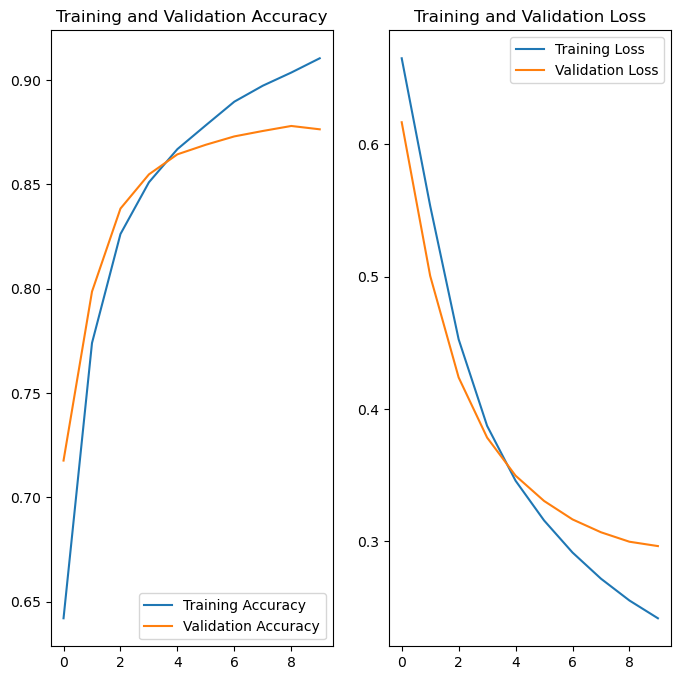

In [42]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

#### Export the model
In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [44]:
#Original code
'''
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])
'''
#I removed the last layer as our original model already has an sigmoid activation dense layer, and it produced accuracy of 0.5

export_model = tf.keras.Sequential([
  vectorize_layer, #add vectorize layer
  model
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8700 - loss: 0.3174
0.8700000047683716


#### Inference on new data
To get predictions for new examples, you can simply call model.predict().

In [49]:
examples = tf.constant([
  "The movie was great!",
  "The movie was amazing.",
  "The movie was terrible...",
  "I loved it!",
  'I dont care.'
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[0.5814512 ],
       [0.5887078 ],
       [0.3075442 ],
       [0.6023857 ],
       [0.40036473]], dtype=float32)

Keeping in mind our threshold is 0.5, we can see the results are relatively accurate.

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this tutorial to learn more about [saving models](https://www.tensorflow.org/tutorials/keras/save_and_load).